# Deep Autoencoders

[![](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/ArashAkbarinia/mbb/blob/main/notebooks/vae.ipynb)

The materials in this notebook are inspired from:
* code
    * https://avandekleut.github.io/vae/
    * https://keras.io/examples/generative/vae/
* article https://arxiv.org/pdf/1906.02691.pdf

This tutorial covers the basics of autoencoders and Variational Autoencoders (VAE). The primary idea behind autoencoder is to learn efficient codings of unlabeled data. The architecture of a deep autoencoder consists of three components:
1. **Encoder** gradually reduces the dimensionality of the input $X$ to a latent space $Z$.
2. **Latent space** (also known as embedding space) is a bottleneck containing the compressed data.
3. **Decoder** reconstructs the signal ($X'$) from the latent space $Z$.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Autoencoder_structure.png/350px-Autoencoder_structure.png"  width="400" height="200">


We measure the success of the network by comparing its output ($X'$) to input ($X$). The closer they are the better.

We explore a few new toy examples all in images of small resolution ($\le32 \times 32$):
* [MNIST](http://yann.lecun.com/exdb/mnist/): grey-scale digit recognition from 0 to 9.

<img src="https://www.researchgate.net/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png"  width="400" height="200">

* [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) grey-scale image recognition among 10 categories.

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png"  width="400" height="200">

* [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html): object recognition among 10 categories.

<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png"  width="400" height="200">

# 0. Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [argparse](https://docs.python.org/3/library/argparse.html) is a module making it easy to write user-friendly command-line interfaces. 
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
import argparse
from matplotlib import pyplot as plt
import random
import os
import math

import torch
import torch.nn as nn
import torchvision

## device

Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## arguments

We use the `argparse` module to define a set of parameters that we use throughout this notebook:
* The `argparse` is particularly useful when writing Python scripts, allowing you to run the same script with different parameters (e.g., for doing different experiments).
* In notebooks using `argparse` is not necessarily beneficial, we could have hard-coded those values directly in variables, but here we use `argparse` for learning purposes.

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0001, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--latent_dim", type=int, default=2, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=500, help="interval between image sampling")
parser.add_argument("--out_dir", type=str, default="./vae_out/", help="the output directory")
parser.add_argument("--dataset", type=str, default="mnist", 
                    choices=["mnist", "fashion-mnist", "cifar10"], help="which dataset to use")

def set_args(*args):
    # we can pass arguments to the parse_args function to change the default values. 
    opt = parser.parse_args([*args])
    # adding the dataset to the out dir to avoid overwriting the generated images
    opt.out_dir = "%s/%s/" % (opt.out_dir, opt.dataset)
    
    # the images in cifar10 are colourful
    if opt.dataset == "cifar10":
        opt.channels = 3
    
    # creating the output directory
    os.makedirs(opt.out_dir, exist_ok=True)
    return opt

In [4]:
opt = set_args("--n_epochs", "5", "--dataset", "mnist")
print(opt)

Namespace(n_epochs=5, batch_size=128, lr=0.0001, b1=0.9, b2=0.999, latent_dim=2, img_size=32, channels=1, sample_interval=500, out_dir='./vae_out//mnist/', dataset='mnist')


# Architecture

In [5]:
class Encoder(nn.Module):
    def __init__(self, opt):
        super(Encoder, self).__init__()
        num_features = 64
        self.main = nn.Sequential(
            # input is ``(opt.channels) x opt.img_size x opt.img_size``
            nn.Conv2d(opt.channels, num_features, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size. ``(num_features) x opt.img_size/2 x opt.img_size/2``
            nn.Conv2d(num_features, num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU(inplace=True),
            # state size. ``(num_features*2) x opt.img_size/4 x opt.img_size/4``
            nn.Conv2d(num_features * 2, num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(inplace=True),
            # state size. ``(num_features*4) x opt.img_size/8 x opt.img_size/8``
            nn.Conv2d(num_features * 4, num_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(inplace=True),
            # state size. ``(num_features*8) x opt.img_size/16 x opt.img_size/16``
            nn.Conv2d(num_features * 8, opt.latent_dim, 2, bias=False),
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, opt):
        super(Decoder, self).__init__()
        self.out_size = (opt.img_size, opt.img_size)
        num_features = 64
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(opt.latent_dim, num_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(True),
            # state size. ``(num_features*8) x 4 x 4``
            nn.ConvTranspose2d(num_features * 8, num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(True),
            # state size. ``(num_features*4) x 8 x 8``
            nn.ConvTranspose2d(num_features * 4, num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU(True),
            # state size. ``(num_features*2) x 16 x 16``
            nn.ConvTranspose2d(num_features * 2, num_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features),
            nn.ReLU(True),
            # state size. ``(num_features) x 32 x 32``
            nn.ConvTranspose2d(num_features, opt.channels, 1, bias=False),
            # state size. ``(opt.channels) x 32 x 32``
            nn.Tanh()
        )

    def forward(self, input):
        x = self.main(input)
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Next, we will write some code to train the autoencoder on the MNIST dataset.

# Dataset

We explore three datasets all already implemented in `torchvision`. The first time will be automatically downloaded (in *"./data/"* directory) the first time if already it doesn't exist.

In [8]:
def get_dataloader(opt, transform):
    if opt.dataset == "mnist":
        dataset = torchvision.datasets.MNIST("./data/", train=True, download=True, transform=transform)
    elif opt.dataset == "fashion-mnist":
        dataset = torchvision.datasets.FashionMNIST("./data/", train=True, download=True, transform=transform)
    else:
        dataset = torchvision.datasets.cifar.CIFAR10("./data/", train=True, download=True, transform=transform)
    return torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)

## Transform functions

We resize all images to specified image size (`opt.img_size`), converting them to `Tensor` and normalising the inputs (`Normalize`).

In [9]:
# make the pytorch datasets
mean = 0.5
std = 0.5
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(opt.img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

dataloader = get_dataloader(opt, transform)

## Visualisation

Let's visualise a few samples from our dataset.

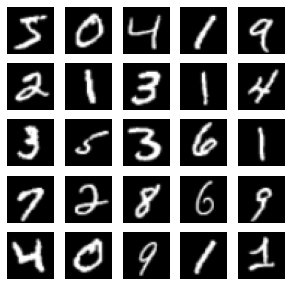

In [10]:
fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

# Training

## Setup Networks and Optimiser

In [11]:
def setup_training(opt, vae=False):
    # Initialise network
    network = VariationalAutoencoder(opt) if vae else Autoencoder(opt)
    network.to(device)

    # Optimiser
    optimizer = torch.optim.Adam(network.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

    return network, optimizer

## Loss

In [12]:
criterion = nn.MSELoss().to(device)

## Utility functions

In [13]:
def sample_image(network, batches_done):
   with torch.no_grad():
       imgs, _ = next(iter(dataloader))
       output = network(imgs.to(device))
   torchvision.utils.save_image(
        output.data, "%s/%.7d.png" % (opt.out_dir, batches_done), nrow=10, normalize=True
    )

The training loop is straightforward:
* We input the autoencoder with input images.
* Computing the loss (`MSE`) of reconstructed outputs with respect to the original images.
* Optimising the network parameters.

In [14]:
def train_instance(opt, vae=False):
    network, optimiser = setup_training(opt, vae)

    losses = []
    for epoch in range(opt.n_epochs):
        # For each batch in the dataloader
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            optimiser.zero_grad()
            output = network(imgs)
            loss = criterion(output, imgs) + (network.encoder.kld if vae else 0)
            loss.backward()
            optimiser.step()

            losses.append(loss.item())
            
            batches_done = epoch * len(dataloader) + i
            if batches_done % opt.sample_interval == 0:
                sample_image(network, batches_done)
                print(
                    "[Epoch %.3d/%d]\t[Batch %.4d/%d]\t[loss: %.4f]"
                    % (epoch, opt.n_epochs, i, len(dataloader), np.mean(losses))
                )
    return network, losses

# Results

Let's train our autoencoder with current arguments (`opt`).

Training progress:
* **loss value** we can observe that the MSE (L2 norm) is gradually decreasing.
* **reconstructed images** By looking at the reconstructed images (in the `opt.out_dir` folder), we can observe that the quality of reconstructed images is quite good, given our latent space contains only 2 units. In other words, each image is compressed into only two numbers.

In [15]:
autoencoder, losses = train_instance(opt)

[Epoch 000/5]	[Batch 0000/469]	[loss: 1.5200]
[Epoch 001/5]	[Batch 0031/469]	[loss: 0.1983]
[Epoch 002/5]	[Batch 0062/469]	[loss: 0.1709]
[Epoch 003/5]	[Batch 0093/469]	[loss: 0.1590]
[Epoch 004/5]	[Batch 0124/469]	[loss: 0.1519]


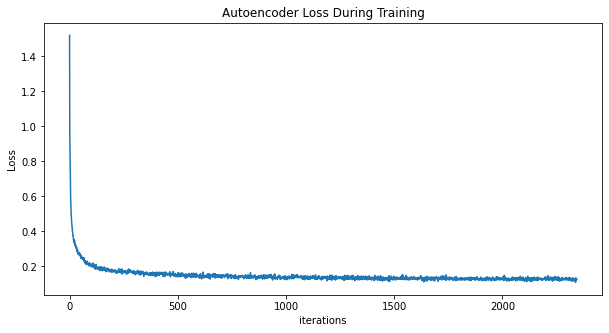

In [16]:
plt.figure(figsize=(10,5))
plt.title("Autoencoder Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

## Reconstructing

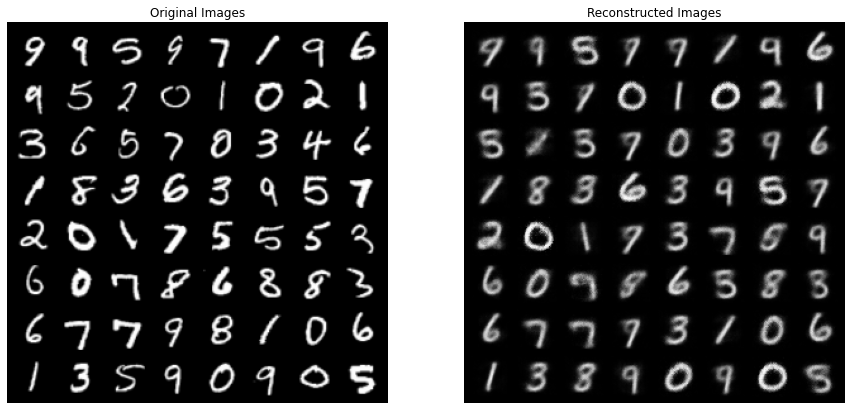

In [17]:
# Grab a batch of real images from the dataloader
org_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(org_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))


with torch.no_grad():
    reconstructed_imgs = autoencoder(org_batch[0].to(device)).detach().cpu()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructed_imgs[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

## Latent space

One interesting aspect of autoencoders is that we can explore the latent space to learn more about the structure of representation in a network.

We create the `plot_latent` function which visualises both dimensions of our latent space, colour-coding each point according to the label of the image. In this function, we only call the **encoder** part of our model.

**Note** This simple visualisation only works if the dimensionality of the latent space is two. For hyperdimensional latent spaces, you can use `sklearn.manifold.TSNE` to reduce the dimensionality to 2.

In [28]:
def plot_latent(autoencoder, dataloader, num_batches=100):
    for i, (imgs, labels) in enumerate(dataloader):
        # only calling the encoder part of our network
        z = autoencoder.encoder(imgs.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
        if i > num_batches:
            cbar = plt.colorbar()
            cbar.set_label('Labels')
            break

We can notice that:
* The latent space of our network has some meaningful structure.
* The range of the x- and y-axis is not the same and the data points are elongated.
* Although categories are relatively separated, there is also some significant degree of overlapping.

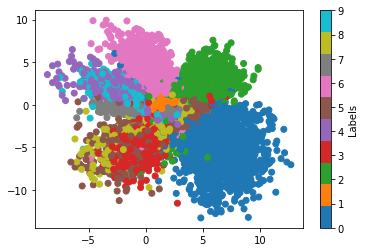

In [29]:
plot_latent(autoencoder, dataloader)

We use the range of values in the x- and y-axis to generate new samples directly from the latent space.

We create a function `plot_reconstructed` that only calls de **decoder** part of our model to uniformly sample from the latent space.

**Note** This simple visualisation only works if the dimensionality of the latent space is two. For hyperdimensional latent spaces, you can use `sklearn.manifold.TSNE` to reduce the dimensionality to 2.

In [20]:
def plot_reconstructed(autoencoder, opt, r0, r1, n=12):
    w = opt.img_size
    img = np.zeros((n*w, n*w, opt.channels)).squeeze()
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).unsqueeze(dim=-1).unsqueeze(dim=-1).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.to('cpu').detach().numpy().squeeze() * std + mean
            if opt.channels == 3:
                x_hat = x_hat.transpose(1, 2, 0)
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gray')

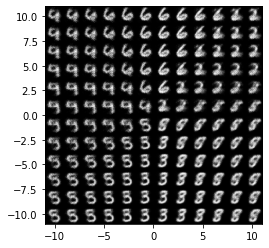

In [30]:
plot_reconstructed(autoencoder, opt, (-11, 11), (-11, 11))

# Variational Autoencoder (VAE)

The latent space ($Z$) of our autoencoder doesn't have any constraint. In VAEs, the encoder maps the input into probability distributions. The decoder receives a sample from these distributions. Specifically, the *encoder* maps the input into two vectors:
* mean vector $\mu(x)$
* standard deviation $\sigma(x)$

The output of *encoder* is reparameterised into $z$ and passed to the *decoder*. Read more about it in [Wikipedia](https://en.wikipedia.org/wiki/Variational_autoencoder).

<img src="https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png">

## Architecture

We implement this in `VariationalEncoder`:
* The sequence of layers in `VariationalEncoder.main` is identical to `Encoder` except the last layer.
* Instead of one `nn.Conv2d(num_features * 8, opt.latent_dim, 2)` we have two corresponding to $\mu$ and $\sigma$.
* The `forward` function is quite different. It calls the `reparameterise` function to sample $z$.

**Note**: we have not changed the **Decoder**.

In [22]:
class VariationalEncoder(nn.Module):
    def __init__(self, opt):
        super(VariationalEncoder, self).__init__()
        num_features = 64
        self.main = nn.Sequential(
            # input is ``(opt.channels) x opt.img_size x opt.img_size``
            nn.Conv2d(opt.channels, num_features, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size. ``(num_features) x opt.img_size/2 x opt.img_size/2``
            nn.Conv2d(num_features, num_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 2),
            nn.ReLU(inplace=True),
            # state size. ``(num_features*2) x opt.img_size/4 x opt.img_size/4``
            nn.Conv2d(num_features * 2, num_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 4),
            nn.ReLU(inplace=True),
            # state size. ``(num_features*4) x opt.img_size/8 x opt.img_size/8``
            nn.Conv2d(num_features * 4, num_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_features * 8),
            nn.ReLU(inplace=True),
        )

        # state size. ``(num_features*8) x opt.img_size/16 x opt.img_size/16``
        self.mu_layer = nn.Conv2d(num_features * 8, opt.latent_dim, 2)
        self.sigma_layer = nn.Conv2d(num_features * 8, opt.latent_dim, 2)

        # Kullback–Leibler divergence
        self.kld = 0
        self.kld_weight = 1e-3

    def reparameterise(self, mu, sigma):
        return mu + sigma * torch.randn_like(mu)

    def set_kld_loss(self, mu, sigma):
        self.kld = sigma.pow(2) + mu.pow(2) - torch.log(sigma) - 0.5
        self.kld = torch.mean(torch.sum(self.kld, dim=1))
        self.kld *= self.kld_weight
        
    def forward(self, x):
        x = self.main(x)
        mu = self.mu_layer(x)
        sigma = torch.exp(self.sigma_layer(x))
        z = self.reparameterise(mu, sigma)
        self.set_kld_loss(mu, sigma)
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Loss

In VAE, we add the [Kullback-Leibler divergence loss](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html) to the MSE loss. We have implemented this in `VariationalEncoder` in the `kld` variable. Therefore, in the `train_instance` function, the loss is computed as:

    loss = criterion(output, imgs) + (network.encoder.kld if vae else 0)

## Results

Let's train a VAE with current arguments (`opt`).

In [32]:
vae_net, losses = train_instance(opt, vae=True)

[Epoch 000/5]	[Batch 0000/469]	[loss: 2.1240]
[Epoch 001/5]	[Batch 0031/469]	[loss: 0.2317]
[Epoch 002/5]	[Batch 0062/469]	[loss: 0.1957]
[Epoch 003/5]	[Batch 0093/469]	[loss: 0.1802]
[Epoch 004/5]	[Batch 0124/469]	[loss: 0.1711]


## Reconstructing

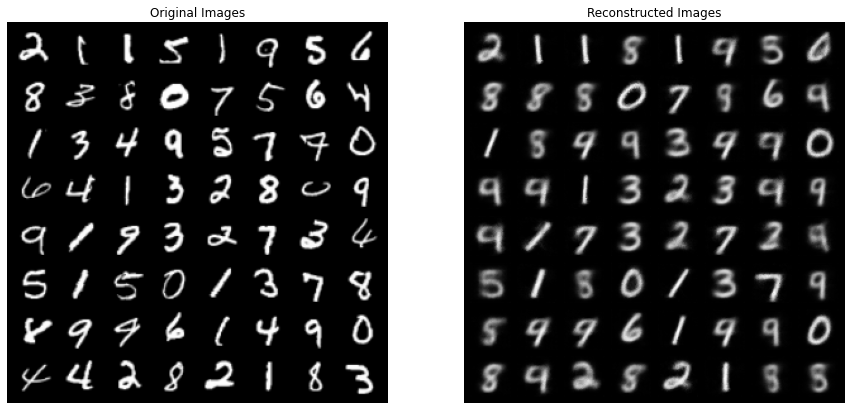

In [33]:
# Grab a batch of real images from the dataloader
org_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(org_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))


with torch.no_grad():
    reconstructed_imgs = vae_net(org_batch[0].to(device)).detach().cpu()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructed_imgs[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

## Latent space

Similar to the autoencoder we can inspect the VAE's latent space. We observe that:
* The distribution of data points resembles a Gaussian distribution (more centralised).
* The range of x- and y-axis are more bound.

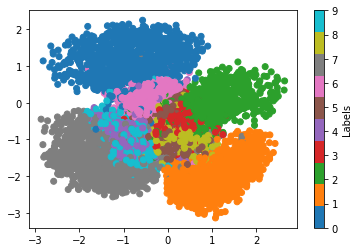

In [34]:
plot_latent(vae_net, dataloader)

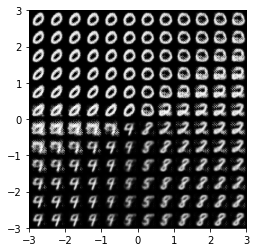

In [35]:
plot_reconstructed(vae_net, opt, (-3, 3), (-3, 3))

# Another dataset

Let's play with another dataset!

Namespace(n_epochs=5, batch_size=128, lr=0.0001, b1=0.9, b2=0.999, latent_dim=100, img_size=32, channels=3, sample_interval=500, out_dir='./vae_out//cifar10/', dataset='cifar10')
Files already downloaded and verified


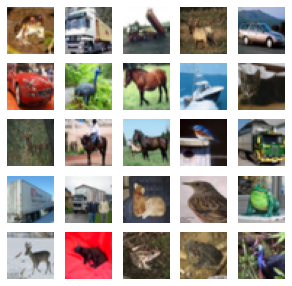

In [38]:
opt = set_args("--n_epochs", "5", "--dataset", "cifar10", "--latent_dim", "100")
print(opt)

dataloader = get_dataloader(opt, transform)

fig = plt.figure(figsize=(5, 5))
for i in range(25):
    img, target = dataloader.dataset.__getitem__(i)
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img.numpy().transpose(1, 2, 0) * std + mean, cmap='gray')
    ax.axis('off')

In [39]:
vae_net, losses = train_instance(opt, vae=True)

[Epoch 000/5]	[Batch 0000/391]	[loss: 0.9570]
[Epoch 001/5]	[Batch 0109/391]	[loss: 0.2267]
[Epoch 002/5]	[Batch 0218/391]	[loss: 0.2030]
[Epoch 003/5]	[Batch 0327/391]	[loss: 0.1884]


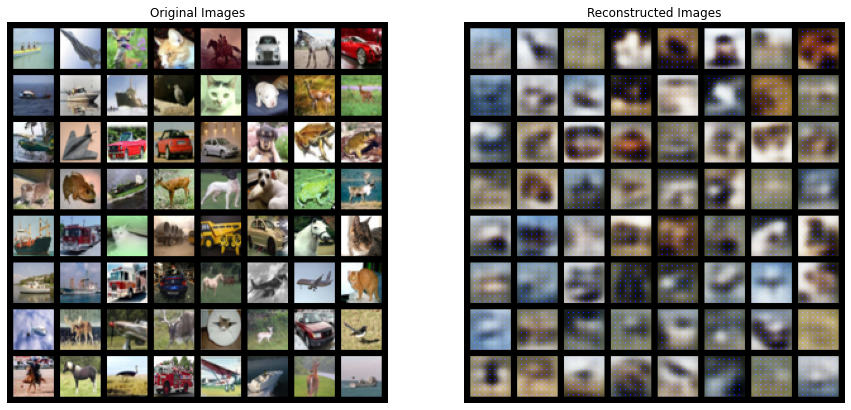

In [40]:
# Grab a batch of real images from the dataloader
org_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(org_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))


with torch.no_grad():
    reconstructed_imgs = vae_net(org_batch[0].to(device)).detach().cpu()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(reconstructed_imgs[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()